
## SML - Assignment 1
### Question 4

#### Implementing ICA Algorithm
Implementing ICA algorithm to separate mixed signals (a sinusoidal wave and a ramp wave)

- Importing Libraries Needed for Implementation of ICA


In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

- For the sinusoidal wave I am plotting the normal $ sin(x) $ wave.
- For the ramp wave, we use the sawtooth function from the Signal library

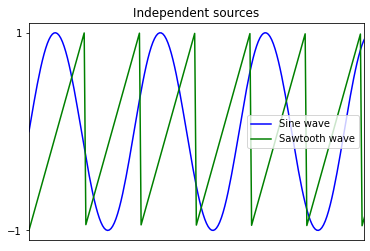

In [2]:
# Generating the input samples by plotting between 0 and 100 with 1000 points
x = np.linspace(0,100,1000)

# Source matrix
# S is a 2x1000 matrix with the first row being the sine wave and the second row being the sawtooth wave
source_matrix = np.array([np.sin(x*1), signal.sawtooth(x*1.9)])

# Plotting our independent sources
plt.plot(x, source_matrix[0], color = 'blue', label = 'Sine wave')
plt.plot(x, source_matrix[1], color = 'green', label = 'Sawtooth wave')
plt.xticks([])
plt.yticks([-1,1])
plt.xlim(x[0], x[200])
plt.title('Independent sources')

# Legend
plt.legend()

# Plotting the source matrix    
plt.show()

#### Mixing the 2 signals using the given Mixing Matrix

In [3]:
# Mixing matrix (provided in the question)
mixing_matrix = np.array([[0.5, 1],
                         [1, 0.5]])  

# Mixing the source matrix with the mixing matrix
res_matrix = (source_matrix.T.dot(mixing_matrix)).T

# The res_matrix is a 2x1000 matrix 
# The first row being the first independent source and the second row being the second independent source
print(res_matrix)

[[-1.         -0.88949407 -0.7794884  ... -0.97606916 -0.87666354
  -0.77430445]
 [-0.5        -0.36979727 -0.24059505 ... -0.98883763 -0.88083551
  -0.76692645]]


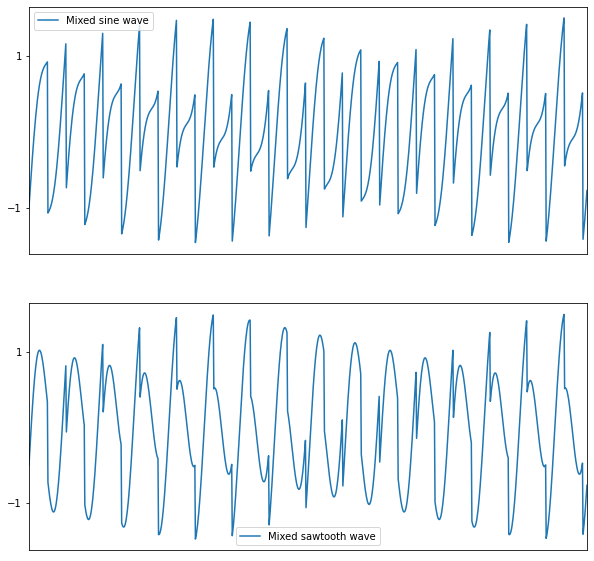

In [4]:
# Plotting the mixed sources
plot, axis = plt.subplots(2,1, figsize = (10,10))
axis[0].plot(x, res_matrix[0], label = 'Mixed sine wave')
axis[1].plot(x, res_matrix[1], label = 'Mixed sawtooth wave')
axis[0].set_xticks([])
axis[0].set_yticks([-1,1])
axis[0].set_xlim(x[0], x[-1])
axis[1].set_xticks([])
axis[1].set_yticks([-1,1])
axis[1].set_xlim(x[0], x[-1])

# Legend
axis[0].legend()
axis[1].legend()

# Plotting the mixed sources
plt.show()


### Pre-processing

#### 1) Step 1 - Centering
$$
z = x_{val} - x_{mean}
$$

In [5]:
# Defining the centering function which takes in a matrix and returns the centered matrix and the mean
def centering(x):
    mean = np.mean(x, axis = 1)
    return x - mean[:, np.newaxis], mean

# Calling the centering function on the res_matrix as first preprocessing step for ICA to center the mixed sources
X_c, mean_centering = centering(res_matrix)
print(X_c)
print(mean_centering)

[[-0.99599974 -0.88549381 -0.77548814 ... -0.9720689  -0.87266327
  -0.77030418]
 [-0.4988407  -0.36863797 -0.23943574 ... -0.98767832 -0.8796762
  -0.76576715]]
[-0.00400026 -0.0011593 ]


#### 2) Step 2 - Whitening:

In [6]:
# Defining the function which returns the covariance matrix of the input matrix
def covariance_matrix(x):
    mean = np.mean(x, axis = 1)
    cov_matrix = x - mean[:, np.newaxis]
    return cov_matrix.dot(cov_matrix.T) / x.shape[1]

# Defining the function which whitens the matrix which has been centered
def whitening(x):
    # Calculating the covariance matrix
    covm = covariance_matrix(x)

    # Single value decomposition
    U, S, V = np.linalg.svd(covm)

    # Calculate the diagonal matrix of eigenvalues
    diagonal_matrix = np.diag(1. / np.sqrt(S + 1e-5))

    # Calculate the whitening matrix
    res_matrix = np.dot(U, np.dot(diagonal_matrix, U.T))

    # Project the data into the new space
    return np.dot(res_matrix, x), res_matrix

# Whitening the centered matrix to whiten the signal
X_w, W = whitening(X_c)

# Printing the covariance matrix of the whitened signal to check if 
print(np.round(covariance_matrix(X_w), 2))

[[1. 0.]
 [0. 1.]]


- We see that our final covariance matrix of the whitened signal is an Identity Matrix of the shape 2x2.
- This verifies that our pre-processing is correct and we have whitened the mixed signals correctly.

### Implementing the ICA Algorithm:

In [7]:
def independent_component_analysis(mixed_signals, epsilon, iterations):
    # m is the number of independent sources
    # n is the number of samples
    m, n = mixed_signals.shape

    # In the first step of the algorithm, the weights are randomly initialized
    # The weights are initialized to a random matrix of size m x m
    weights = np.random.rand(m, m)

    # Now we iterate over each of the 2 rows of the mixed signals corresponding to the 2 independent sources
    for i in range(m):

        # We initialize the weights for the ith row of the mixed signals
        wi = weights[i, :].copy()

        # Converting wi to a unit vector
        wi = wi / np.linalg.norm(wi)

        # We iterate over the number of iterations
        for j in range(iterations):
            
            # Dot product of the weights and the mixed signals
            # We would be needing this in our tanh() functions for updating weights
            wi_dot_x = np.dot(wi.T, mixed_signals)

            # tanh() function
            tan_h = (np.tanh(wi_dot_x)*mixed_signals).mean(axis = 1)

            # tanh() derivative function
            tan_h_derivative = (1 - np.tanh(wi_dot_x)**2).mean() * wi.squeeze()

            # Updating the weights
            w_new = tan_h - tan_h_derivative

            # Converting the new weights to a unit vector
            w_new = w_new / np.linalg.norm(w_new)

            # We adjust the new weights 
            w_new = w_new - np.dot(np.dot(w_new, weights[:i, :].T), weights[:i, :])

            # Converting the new weights to a unit vector
            w_new = w_new / np.linalg.norm(w_new)

            # Limiting condition for the algorithm
            if(np.abs(np.abs((w_new * wi).sum()) - 1) < epsilon):
                break

            # Updating the weights
            wi = w_new
        
        # Updating the weights for the ith row
        weights[i, :] = wi.T    

    # Returning the weights
    return weights

In [8]:
# Calling the ICA algorithm on the whitened matrix
weights = independent_component_analysis(X_w, 1e-5, 1000)

# Unmix the signals using the weights obtained
unmixed_signals = np.dot(weights.T, X_w)

# Subtracting the mean from the unmixed signals
unmixed_signals = (unmixed_signals.T - mean_centering).T
print(unmixed_signals)

[[-9.05670616e-04  1.40367947e-01  2.80229205e-01 ... -9.42329737e-01
  -8.32395839e-01 -7.14123356e-01]
 [-1.71679459e+00 -1.61151785e+00 -1.50624909e+00 ... -1.10462275e+00
  -9.99523033e-01 -8.94376215e-01]]


### Plotting the Independent Sources

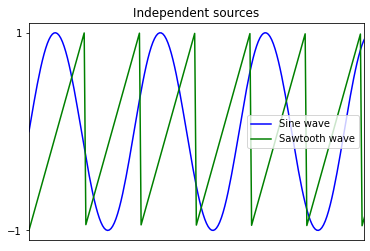

In [9]:
# Plotting our independent sources
plt.plot(x, source_matrix[0], color = 'blue', label = 'Sine wave')
plt.plot(x, source_matrix[1], color = 'green', label = 'Sawtooth wave')
plt.xticks([])
plt.yticks([-1,1])
plt.xlim(x[0], x[200])
plt.title('Independent sources')

plt.legend()
plt.show()


### Plotting the Unmixed Signals from ICA

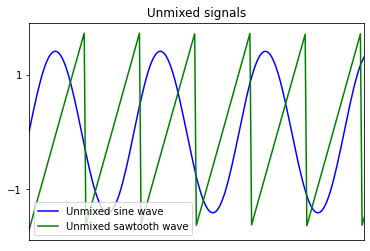

In [10]:
# Plotting the unmixed signals
plt.plot(x, unmixed_signals[0], color = 'blue', label = 'Unmixed sine wave')
plt.plot(x, unmixed_signals[1], color = 'green', label = 'Unmixed sawtooth wave')
plt.xticks([])
plt.yticks([-1,1])
plt.xlim(x[0], x[200])
plt.title('Unmixed signals')

plt.legend()
plt.show()

- We see that we have reconstructed back the signals after mixing them using the technique of Independent Component Analysis (ICA).